# Hourly Data #

In [2]:
# imports
import pandas as pd
import numpy as np
import time

In [3]:
# define data location
#location = '/Users/mithras/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'
location = '/Users/loki/Documents/Data/Forecasting Project/'

## Data Cleaning & Checking 

In [5]:
# hourly data
use_jan_in = pd.read_excel(location+'Zip_HourlylUsage_2018.01.xlsx')
use_jul_in = pd.read_excel(location+'Zip_HourlylUsage_2018.07.xlsx')

# daily data
use_oct_in = pd.read_excel(location+'Sample Usage_2017.10 Oct.xlsx')
use_nov_in = pd.read_excel(location+'Sample Usage_2017.11 Nov.xlsx')
use_dec_in = pd.read_excel(location+'Sample Usage_2017.12 Dec.xlsx')
# use_jan_in = pd.read_excel(location+'Sample Usage_2018.01 Jan.xlsx')
use_feb_in = pd.read_excel(location+'Sample Usage_2018.02 Feb.xlsx')
use_mar_in = pd.read_excel(location+'Sample Usage_2018.03 March.xlsx')
use_apr_in = pd.read_excel(location+'Sample Usage_2018.04 April.xlsx')
use_may_in = pd.read_excel(location+'Sample Usage_2018.05 May.xlsx')
use_jun_in = pd.read_excel(location+'Sample Usage_2018.06 June.xlsx')
# use_jul_in = pd.read_excel(location+'Sample Usage_2018.07 Jul.xlsx')
use_aug_in = pd.read_excel(location+'Sample Usage_2018.08 Aug.xlsx')
use_sep_in = pd.read_excel(location+'Sample Usage_2018.09 Sep.xlsx')

# other data
customer_in = pd.read_excel(location+'PECO Zip Customer 2018.10.01 v2.xlsx', sheet_name="Account")
#ratecode_in = pd.read_excel(location+'Rate Codes for Drexel 9_28_2018.xlsx')


In [6]:
# merge use data
daily_in = [use_oct_in, use_nov_in, use_dec_in, use_feb_in, use_mar_in, 
            use_apr_in, use_may_in, use_jun_in, use_aug_in, use_sep_in]
daily = pd.concat(daily_in)
daily = daily.rename(columns={'DAccountID':'DACCOUNTID', 'DMeterNo':'DMETERNO',
                              'DAILY_INTERVAL_USAGE':'Use'})

hourly_in = [use_jan_in, use_jul_in]
hourly = pd.concat(hourly_in)

In [7]:
# create ID tuple
ids = pd.Series(list(map(tuple, daily[['DACCOUNTID', 'DMETERNO']].values)))
daily['ID'] = ids.values

ids = pd.Series(list(map(tuple, hourly[['DACCOUNTID', 'DMETERNO']].values)))
hourly['ID'] = ids.values

ids = pd.Series(list(map(tuple, customer_in[['DACCOUNTID', 'DMETERNO']].values)))
customer_in['ID'] = ids.values

In [8]:
# find gas records
daily = daily.loc[daily['UOM'] == 'CCF']
daily = daily.drop(columns=['UOM'])
hourly = hourly.loc[hourly['UOM'] == 'CCF']
hourly = hourly.drop(columns=['UOM'])

customer = customer_in.drop(columns=['CITY', 'STATE', 'ZIPCODE', 'COUNTYCODE'])

# convert to datetime
daily['Dt'] =  pd.to_datetime(daily['METERREADDATE'])
hourly['Dt'] =  pd.to_datetime(hourly['METERREADDATE'])

## Data Restructuring ##

In [9]:
# functions for naming consistency
def decrement(x, startswith, split):
    """
    decrements a passed string of form "demo#" by 1
    
    Parameters
    ----------
    x : string to be decremented
    split : string to split on

    Returns
    ----------
    y : decremented string
    """
    if x.startswith(startswith):
        a,b = x.split(split)
        b = int(b)-1
        y = a + split + str(b)

        return y

    else:
        return x

    
def interval_to_hour(df):
    """
    function for fast rename/relabel during tidying process
    
    Parameters
    ----------
    df : pandas data frame

    Returns
    ----------
    df : data frame with updated column names
    """
    
    df = df.rename(columns=lambda x: decrement(x, "INTERVAL_", "_"))
    df = df.rename(columns=lambda x: x.replace("INTERVAL_", "HR"))
    return df

In [10]:
# rename for consistency
hourly = interval_to_hour(hourly)
hourly = hourly.drop(columns=['METERREADDATE','HR24'])
daily = daily.drop(columns=['METERREADDATE'])

In [11]:
# Tidy / Stack data (transform into tall data - one row per customer per hour):
# ref: http://www.jeannicholashould.com/tidy-data-in-python.html
tidy_hourly = pd.melt(hourly, 
                      id_vars=['ID','DACCOUNTID','DMETERNO','Dt'],
                      var_name='Hour', value_name='Use')

tidy_hourly_agg = tidy_hourly.groupby(['ID','DACCOUNTID','DMETERNO','Dt']).sum().reset_index()
#tidy_hourly_agg.head()

In [12]:
# join hourly & daily
dfs = [tidy_hourly_agg, daily]
use = pd.concat(dfs, keys=['ID','DACCOUNTID', 'DMETERNO', 'Dt', 'Use'], sort=True).reset_index(drop=True)
#use.head()

In [13]:
# append rate code data
use = use.merge(customer, how='inner', on=['ID','DACCOUNTID','DMETERNO'])
#use.head()

In [14]:
# Add dummy variables for day-of-week
use = use.join(pd.get_dummies(use['Dt'].dt.weekday_name))

# Add dummy variables for holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
dr = pd.date_range(start=min(use['Dt']), end=max(use['Dt']))
holidays = cal.holidays(start=dr.min(), end=dr.max())

use = use.join(pd.get_dummies(use['Dt'].isin(holidays)))
use = use.rename(columns={True:'Holiday'})
use = use.drop(columns=[False])
#use.head()

In [15]:
# sort by date & time
use = use.sort_values(by=["Dt"])

#### Quick look at amount of data we have per ID ####

In [16]:
# drop records with missing data
if len(use) == len(use.dropna(subset=['Use'])):
    print(f'There is no missing data in the {len(use)} rows of useage data')
else:
    use = use.dropna(subset=['Use'])

There is no missing data in the 2279443 rows of useage data


In [17]:
print(f"There are {len(use['DACCOUNTID'].drop_duplicates())} unique AccountIDs in the data")
print(f"There are {len(use['DMETERNO'].drop_duplicates())} unique MeterNos in the data")
ids = use['ID'].drop_duplicates()
print(f"There are {len(ids)} unique AccountID / MeterNo pairs in the data")

There are 6976 unique AccountIDs in the data
There are 6953 unique MeterNos in the data
There are 7097 unique AccountID / MeterNo pairs in the data


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
ids_to_plot = use.groupby('ID').count()
sns.distplot(ids_to_plot['Use'], bins=20, kde=False, rug=False)
plt.title('Frequency of IDs with X dates')

Text(0.5, 1.0, 'Frequency of IDs with X dates')

Text(0.5, 1.0, 'Frequency of IDs with at least 330 dates')

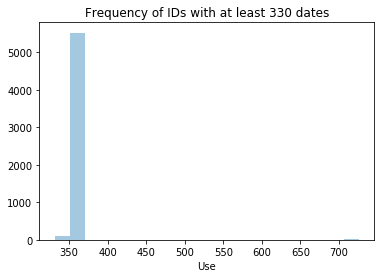

In [19]:
sns.distplot(ids_to_plot[ids_to_plot['Use'] > 330]['Use'], bins=20, kde=False, rug=False)
plt.title('Frequency of IDs with at least 330 dates')

In [20]:
#for i in range(1,365):
#    print(f"{ids_to_plot[ids_to_plot['Use'] >= i]['Use'].count()} records have >={i} dates")

#### Find IDs with sufficient data to build initial segments on --> reliable training set ####

In [21]:
# find IDs with at least 360 days of data
sufficient_ids = ids_to_plot[ids_to_plot['Use'] >= 360].reset_index()['ID']
print(f"{100*len(sufficient_ids)/len(use['ID'].unique())} percent of IDs have at least 360 days of data")

76.90573481752854 percent of IDs have at least 360 days of data


In [22]:
# find the dates for which sufficient_ids all have data
pivoted = (use[use['ID'].isin(sufficient_ids)]
           .pivot_table(index='Dt', columns=['ID'], values='Use', fill_value=None))
sufficient_dates = pivoted.dropna().reset_index()['Dt']
print(f"The IDs with sufficient data overlap on {len(sufficient_dates)} days of the most recent year of data")

The IDs with sufficient data overlap on 322 days of the most recent year of data


In [23]:
# filter total use dataset to contain only IDs who have sufficient data and only dates where sufficient_ids have data
sufficient_use = use[(use['ID'].isin(sufficient_ids)) & (use['Dt'].isin(sufficient_dates))]
#sufficient_use.head()

In [41]:
#sanity check
print(len(use))
print(len(sufficient_use))
print(len(ids))
print(len(sufficient_ids))

2279443
1767458
7097
5458


### Subgroup detection ###

In [7]:
print(use[['ID','REVENUCODE']].drop_duplicates().groupby('REVENUCODE').count())
print("nan           "+str(len(use[np.isnan(use['REVENUCODE'])][['ID']].drop_duplicates())))

              ID
REVENUCODE      
1.0         5815
3.0          862
5.0           22
12.0         398
nan           33


In [8]:
print(use[['ID','REVENUCODE']].drop_duplicates().groupby('REVENUCODE').count())
print("nan           "+str(len(use[np.isnan(use['REVENUCODE'])][['ID']].drop_duplicates())))

              ID
REVENUCODE      
1.0         5815
3.0          862
5.0           22
12.0         398
nan           33


In [10]:
# recode 'REVENUCODE' as 'TYPE'
def recode(df):
    """combines REVENUCODE groups 1,12,nan to HOME and 3,5 to COMMERICAL"""
    df['TYPE'] = None
    df.loc[ df.REVENUCODE == 1, 'TYPE' ] = 'HOME'
    df.loc[ df.REVENUCODE == 12, 'TYPE' ] = 'HOME'
    df.loc[ np.isnan(df['REVENUCODE']), 'TYPE' ] = 'HOME'
    df.loc[ df.REVENUCODE == 3, 'TYPE' ] = 'COMM'
    df.loc[ df.REVENUCODE == 5, 'TYPE' ] = 'COMM'
    
    #df['TYPE'][df['REVENUCODE']==1] = 'HOME'
    #df['TYPE'][df['REVENUCODE']==12] = 'HOME'
    #df['TYPE'][np.isnan(df['REVENUCODE'])] = 'HOME'
    #df['TYPE'][df['REVENUCODE']==3] = 'COMM'
    #df['TYPE'][df['REVENUCODE']==5] = 'COMM'
    
    return df

In [11]:
# ignore errors
use = recode(use)
sufficient_use = recode(sufficient_use)

### Save ###

In [42]:
# save file(s) as pickles
# using save location to save with other data files outside of git repo
# data.to_csv(location+'peco.csv', sep='\t')
use.to_pickle(location+'peco_daily.pkl.zip')
sufficient_use.to_pickle(location+'peco_sufficient_daily.pkl.zip')
ids.to_pickle(location+'peco_daily_ids.pkl.zip')
sufficient_ids.to_pickle(location+'peco_sufficient_daily_ids.pkl.zip')

 ### Merge use & weather? ###

In [6]:
# load data
daily = pd.read_pickle(location+'peco_daily.pkl.zip')
sufficient_daily = pd.read_pickle(location+'peco_sufficient_daily.pkl.zip')
weather = pd.read_pickle(location+'daily_weather.pkl.zip')

In [ ]:
# merge
daily = pd.merge(daily, weather, how='inner', on=['Dt'])
sufficient_daily = pd.merge(sufficient_daily, weather, how='inner', on=['Dt'])
# CustIDs || Date | Consumption |||| Weather_variables